In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

## S&P GSCI

The S&P GSCI (formerly the Goldman Sachs Commodity Index) is a benchmark for investment in the commodity markets and serves as a measure of commodity performance over time. It is composed of 24 exchange-traded futures contracts that cover physical commodities across five sectors. The index is weighted by the average production of each commodity over the last five years.
These sectors are:

- Energy
- Industrial Metals
- Precious Metals
- Agriculture
- Livestock



Let's download the data from January,2018 to September, 2023 for S&P GSCI from yahoo finance with interval of 1 day.

In [14]:
# Downlaod data from yfinance and store it in dataframe
df = yf.download('^SPGSCI', start="2018-01-01", end="2023-09-01", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,442.440002,444.660004,441.540009,442.720001,442.720001,0
2018-01-03,442.720001,447.559998,441.920013,447.140015,447.140015,0
2018-01-04,447.140015,449.429993,446.500000,447.829987,447.829987,0
2018-01-05,447.829987,448.100006,442.640015,443.760010,443.760010,0
2018-01-08,443.769989,445.570007,442.510010,443.760010,443.760010,0


Plot of the price for S&P GSCI from January, 2018 to September, 2023

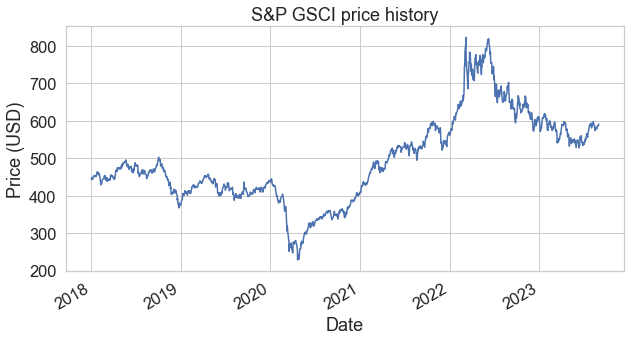

In [ ]:
# Adjusted close price plot 
df['Adj Close'].plot(xlabel='Date', ylabel='Price (USD)', title='S&P GSCI price history', figsize=(10, 5));

Let's take a look at the returns of the S&P GSCI.

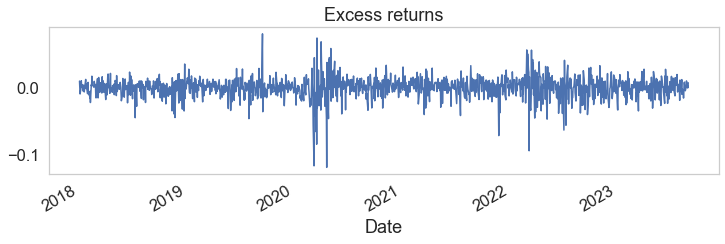

In [ ]:
# Retruns 
returns = df['Adj Close'].pct_change().dropna()

returns.plot(title='Excess returns', figsize=(12, 3), grid=False);

Plot of return depicts some regimes of high volatility. There are some dramatic spikes suggest that there are some regimes characterized described by price returns variance.

To solidify the fact we move to Markov switching autoregression.

**Markov Switching Autoregression**

A Markov Switching model is a popular regime-switching model that rests on the assumption that unobserved states are determined by an underlying stochastic process known as a Markov-chain. A Markov-chain is a system describing possible events in which the probability of each event depends only on the state attained in the previous event.

In [26]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(returns.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1425
Model:               MarkovRegression   Log Likelihood                4123.397
Date:                Mon, 23 Oct 2023   AIC                          -8238.793
Time:                        16:00:18   BIC                          -8217.746
Sample:                             0   HQIC                         -8230.932
                               - 1425                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   7.13e-06     16.828      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0009      0.000      7.306      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9853      0.005    183.200      0.000       0.975       0.996
p[1->0]        0.0844      0.029      2.882      0.004       0.027       0.142
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [27]:
res_kns.smoothed_marginal_probabilities.head()

,0,1
Date,,
2018-01-03,0.987761,0.012239
2018-01-04,0.994659,0.005341
2018-01-05,0.996747,0.003253
2018-01-08,0.997950,0.002050
2018-01-09,0.998024,0.001976


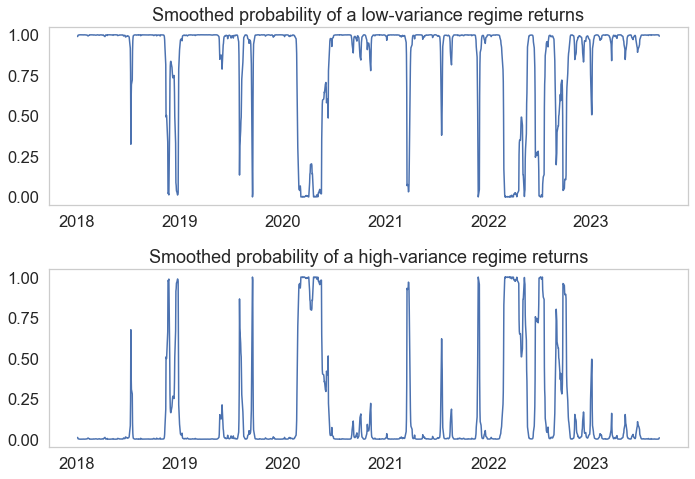

In [28]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [29]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [30]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

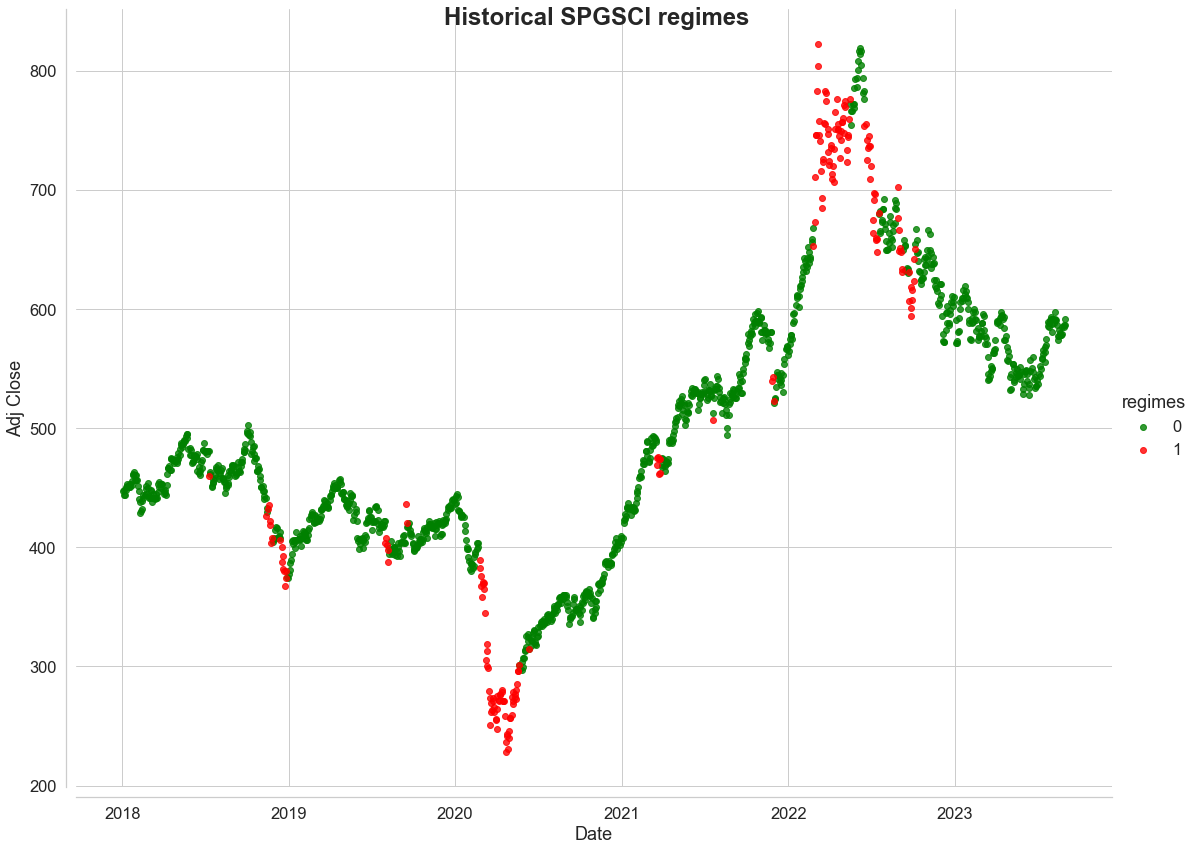

In [33]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPGSCI regimes', fontsize=24, fontweight='demi');

## **1. Regime Changes and the EM Algorithm: An Application for VIX**

Now we are going to develop a specific application where we will estimate a regime-switching model for the daily realizations of the CBOE's VIX index, which is a popular measure of the stock market's expectation of volatility based on S&P 500 index option volatilities.

Assume that the observable VIX process is $y_{t}= \mu_t + \varepsilon_t$, where $\varepsilon_t$ is drawn from a normal distribution with mean zero and variance $\sigma_t^2$. The conditional mean and variance of the process at each time both depend on the outcome of a Markov process with $N$ possible realizations, i.e., we have a tuple $\{(\mu_i,\sigma_i)_{i=1}^N\}$ and an associated transition matrix P.

As in the previous example, we are going to follow the Hamilton filter process. However, we are going to apply a smoothing method that allows us to obtain inferences about the probability of each state that conditions on the whole observable process $\mathcal{Y}_T$:
$$
\begin{align}
\xi_{t|T}(j) = \xi_{t|t}(j) \sum_{i=1}^N p_{ji} \frac{\xi_{t+1|T}(i)}{\xi_{t+1|t}(i)}
\end{align}
$$
These smoothed probabilities are computed backwards, starting with $\xi_{T|T}(j)$ as it arose from the forward recursion developed above. This procedure is called the Kim smoother, as developed by Kim (1993).

Thus, the log-likelihood function can be expressed as:
$$
\begin{align}
\mathcal{L}(\theta) = \sum_{t=1}^T log\ f(y_t|\mathcal{Y}_{t-1};\theta) = \sum_{t=1}^T log\ \sum_{i=1}^N \xi_{t|T}(i) \times \phi_{t}(i)
\end{align}
$$
where $\phi_{t}(i)=\phi\left(\frac{y_t-\mu_i}{\sigma_i}\right)$.

In the previous example, we opted for a "brute force" maximization of the likelihood, but we are now going to develop a particular procedure that reduces the computational burden of this type of problem. This procedure is a version of the Expectation-Maximization (EM) algorithm. 

In the first step, Expectation (E), we assume that we know the actual path of the unobservable Markov process $\mathcal{S}_t$. In that case, we would have that:
$$
\begin{align}
\mathbb{P}(y_t,s_t=i|\mathcal{Y}_{t-1},\mathcal{S}_{t-1};\theta) & = \mathbb{P}(y_t|\mathcal{S}_{t};\theta)\mathbb{P}(s_t=i|\mathcal{S}_{t-1};\theta) \\ & = \phi_{t}(i)\prod_{j=1}^N \mathbb{P}(s_t=i|s_{t-1}=j;\theta)^{\mathbb{I}(s_{t-1}=j;\theta)} \\ & = \phi_{t}(i)\prod_{j=1}^N p_{ji}^{\mathbb{I}(s_{t-1}=j;\theta)}
\end{align}
$$
where $\mathbb{I}(s_{t-1}=j;\theta)$ is an indicator variable that denotes if state $j$ was realized at $t-1$. Then, the joint log-likelihood of the observations can be expressed as:
$$
\begin{align}
log\ \mathbb{P}(y_t,s_t=i|\mathcal{Y}_{t-1},\mathcal{S}_{t-1};\theta) = log\ \phi_{t}(i) +  \sum_{j=1}^M  log\ p_{ji} \times {\mathbb{I}(s_{t-1}=j;\theta)}
\end{align}
$$
Because at $t=1$ we do not observe any past history, we need to estimate or fix in advance an initial probability $\pi_j$ such that:
$$
\begin{align}
log\ \mathbb{P}(y_1,s_1=i;\theta) = log\ \phi_{t}(i) + log\ \pi_{i}
\end{align}
$$
We can now build the following log-likelihood function that considers all the potential realizations of $s_t$ (the "complete" likelihood):
$$
\begin{align}
\mathcal{L}(\theta;\mathcal{Y}_T,\mathcal{S}_T) = & \sum_{t=1}^T \sum_{i=1}^N \mathbb{I}(s_{t}=i;\theta) log\ \phi_{t}(i) + \\ & +  \sum_{t=2}^T \sum_{i=1,j=1}^N \mathbb{I}(s_{t}=i;\theta)\mathbb{I}(s_{t-1}=j;\theta) log\ p_{ji} + \\ 
& +  \sum_{i=1}^N \mathbb{I}(s_{1}=i;\theta)log\ \pi_{ij}
\end{align}
$$
The crucial step now is to take the expectation of the expression above by substituting the indicators $\mathbb{I}(s_{t}=j;\theta)$ with the corresponding probabilities estimated above $\xi_{t|T}(j)$. The terms $\mathbb{I}(s_{t}=j;\theta)\mathbb{I}(s_{t-1}=i;\theta)$ can be replaced by $p_{ij}\xi_{t|t}(i)\xi_{t+1|T}(j)/\xi_{t+1|t}(j)$ that arises from the each specific component of the Kim filter that arises from each state $j$.

With all these ingredients, we have completed the E step, given a guess for the parameter vector $\theta=\{(\mu_i,\sigma_i)_{i=1}^N,(p_{ij})_{i,j=1}^N\}$.

In the maximization step, instead of trying to optimize in a single step as we did in the previous lecture, we generate a series of parameter estimates $\theta^{(k)}$, such that:
$$
\begin{align}
\theta^{(k)} = \arg\underset{\theta}{\max} E\left[\mathcal{L}(\theta;\mathcal{Y}_T,\mathcal{S}_T)|\mathcal{Y}_T;\theta^{(k-1)}\right]
\end{align}
$$
Until we reach convergence.

Indeed, the assumption of normality allows us to reach a sequence of estimates with analytical expressions. At step $k$, with the guessed vector of parameters $\theta^{(k-1)}$, differentiation of the log-likelihood function with respect to $\sigma_i$ yields:
$$
\begin{align}
\frac{\partial \sum_{t=1}^T \xi_{t|T}^{(k-1)}(i)\ log\ \phi_{it}}{\partial \sigma_i} = \sum_{t=1}^T \xi_{t|T}^{(k-1)}(i)\ \left(\frac{(y_t-\mu_i)^2}{\sigma_i^2}-1\right) = 0
\end{align}
$$
So that,
$$
\begin{align}
\sigma_i^{(k)} = \sqrt{\frac{\sum_{t=1}^T \xi_{t|T}^{(k-1)}(i) \left(y_t-\mu^{(k)}_{-1}\right)^2}{\sum_{t=1}^T \xi_{t|T}^{(k-1)}(i)}}
\end{align}
$$
The expression is just the squared root of a weighted average of the squared deviations of the process, where the weights are the relative estimated probability of state $i$ occurring. Differentiation with respect to $\mu_i^{(k)}$ yields:
$$
\begin{align}
\sum_{t=1}^T \xi_{t|T}^{(k-1)}(i) \frac{y_t-\mu_i^{(k)}}{\left(\sigma_i^{(k)}\right)^2} = 0
\end{align}
$$
The corresponding estimates $\mu_i^{(k)}$, are just averages that are weighted by the estimated probability that the process is in state $i$ at each date $t$:
$$
\begin{align}
\mu_i^{(k)} = \frac{\sum_{t=1}^T \xi_{t|T}^{(k-1)}(i) y_t}{\sum_{i=1}^M \xi_{t|T}^{(k-1)}(i)}
\end{align}
$$
Finally, we can show that the estimates for the transition matrix and the initial distribution are given by:
$$
\begin{align}
& p_{ij}^{(k)} = \frac{\sum_{t=2}^T p_{ij}^{(k-1)}\xi_{t-1|t-1}(i)\xi_{t|T}(j)/\xi_{t|t}(j)}{\sum_{t=2}^T \xi_{t-1|T}^{(k-1)}(i)} \\
& \pi_i^{(k)} = \xi_{1|T}^{(k-1)}(i)
\end{align}
$$
Notice the resemblance of the solution $p_{ij}^{(k)}$ with the MLE estimate for the transition probabilities we learned in the first lesson. We now have all the ingredients to set the optimization algorithm and estimate the parameters. First, define again the functions needed to estimate the model:

In [ ]:
# Estimation of model with changes in volatility regimes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# Estimation of model with changes in volatility regimes
# Build function that performs the E step
# Likelihood of an observation


def likelihood(xi_prob, mu, sigma, y):
    phi = norm.pdf((y - mu) / sigma)
    y_like = np.dot(xi_prob, phi)

    return y_like


# Hamilton filtering
def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    y_like = likelihood(pi_hat0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma[ss2])
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma[ss2])
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1


# Kim filtering
def backward_alg(xi_prob_t, xi_prob_t1, N, T, P, mu, sigma, Y):
    xi_prob_T = np.zeros((T, N))
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]

    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(0, N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T  # , xi_prob_T1


def M_step_func(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat

Now we read and plot the evolution of the daily VIX. Notice the remarkable spikes in the index in some periods associated with greater volatility in the index. This behavior makes it reasonable to apply a regime-switching model to understand the behavior of VIX.

In [ ]:
# Read data
PData = pd.read_csv("VIX_History_L4.csv")

YDatapd = PData[["CLOSE"]]
YData = YDatapd.to_numpy()
YData = np.log(YData)
plt.plot(YData)
plt.title("VIX time series")

fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

Now let's estimate the model. At each iteration step, a figure plots the estimated probabilities of each state at each day. Notice that it is going to take several minutes until the model satisfies the convergence tolerance.

In [ ]:
# Initialize parameters
T = len(YData)
N = 2

# SET INITIAL GUESSES

mu_hat0 = [2, 4] * np.ones((N))
sigma_hat0 = [0.1, 0.1] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-2

for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # M-step
    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    diff = np.zeros((4))
    diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
    diff[1] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (
        np.min(sigma_hat0) + itetol * 1e-2
    )
    diff[2] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (
        np.min(P_hat0) + itetol * 1e-2
    )
    diff[3] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)

    print(ite, np.max(diff))

    if np.max(diff) > itetol:
        mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1
    else:
        print(mu_hat1, sigma_hat1, P_hat1, pi_hat1)
        break

Notice how the estimation clearly identifies long periods of time with high levels and volatility of the VIX, while other periods of time include episodes of low and high volatility that the model encounters difficulties disentangling. That is, during those episodes, the probabilities of low or high VIX are roughly 50%. Also, check that the estimated transition matrix shows that the high + volatile regime of VIX is the most usual outcome.

The procedure above can be easily extended to include more elaborated dynamics that might improve the outcome of the model while retaining the Markovian properties. See Hamilton (Chapter 22, 1994). 

*Note: The version of the EM algorithm introduced above has been developed in a more or less independent fashion across different fields. For instance, in the speech recognition or cryptanalysis fields, an analogous version of Hamilton-Kim filtering plus the EM algorithm is known as the Baum-Welch algorithm. Indeed, the Baum-Welch algorithm was developed before the actual EM algorithm was proposed by Dempster, Laird, and Rubin.*